In [26]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

In [3]:
data = pd.read_csv("telco_data_encoded.csv")
data.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MultipleLines_No phone service,MultipleLines_Yes
0,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,1,0,0,0,34,1,1,0,1,0,...,0,0,0,1,0,0,0,1,0,0
2,1,0,0,0,2,1,1,1,0,0,...,1,0,0,0,0,0,0,1,0,0
3,1,0,0,0,45,0,1,0,1,1,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,2,1,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0


In [4]:
print(data.columns)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetService_Fiber optic', 'InternetService_No',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'MultipleLines_No phone service', 'MultipleLines_Yes'],
      dtype='object')


In [5]:
data.drop(columns=['tenure'], inplace=True)
y = data['Churn']
X = data.drop(columns=['Churn'])

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(y_train.value_counts())

Churn
0    4130
1    1495
Name: count, dtype: int64


In [7]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train= sc.fit_transform(X_train)
X_test= sc.transform(X_test)

In [8]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=42)
X_train, y_train = smt.fit_resample(X_train, y_train)
print(y_train.value_counts())

Churn
0    4130
1    4130
Name: count, dtype: int64


In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score, ConfusionMatrixDisplay, r2_score
clf_name = []
roc_auc = []
f1 = []
def model_eval(clf, y_test, y_pred):
    print(classification_report(y_test, y_pred))
    cm=confusion_matrix(y_test, y_pred, labels=y_test.unique())
    disp = ConfusionMatrixDisplay(cm, display_labels=y_test.unique())
    disp.plot(cmap='cividis')
    m1 = roc_auc_score(y_test, y_pred)
    m2 = f1_score(y_test, y_pred)
    print('ROC_AUC_Score: {:.04f}'.format(m1))
    print('F1 Score: {:.04f}'.format(m2))
    clf_name.append(clf)
    roc_auc.append(m1)
    f1.append(m2)

# Base Random Forrest Model

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1033
           1       0.56      0.57      0.57       374

    accuracy                           0.77      1407
   macro avg       0.70      0.71      0.71      1407
weighted avg       0.77      0.77      0.77      1407

ROC_AUC_Score: 0.7071
F1 Score: 0.5695


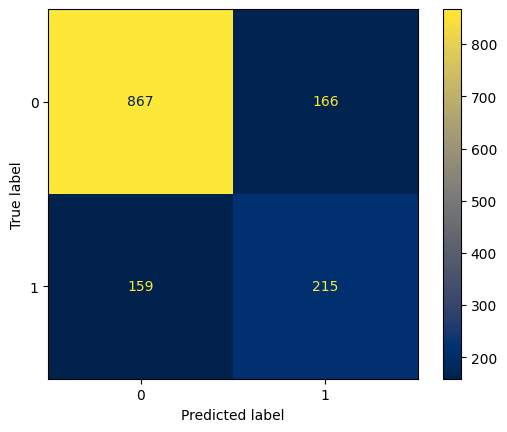

In [27]:
y_pred_baseRf = rf_clf.predict(X_test)
model_eval(rf_clf,y_test,y_pred_baseRf)

In [ ]:
rf_importances = pd.DataFrame({
    'Feature': X.columns,  
    'Importance': rf_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

fig = px.bar(
    rf_importances, 
    x='Importance', 
    y='Feature', 
    orientation='h', 
    title='Feature Importance - Random Forest',
    labels={'Importance': 'Importance', 'Feature': 'Feature'},
    height=600
)

fig.update_layout(yaxis=dict(autorange="reversed")) 
fig.show()

# XGBoost Model

In [21]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(
    n_estimators=200,         
    max_depth=6,              
    learning_rate=0.1,      
    subsample=0.8,            # Fraction of samples used for training each tree
    colsample_bytree=0.8,     # Fraction of features used per tree
    gamma=1,                  # Minimum loss reduction to split
    reg_alpha=0.1,            # L1 regularization
    reg_lambda=1,             # L2 regularization
    random_state=42           
)

xgb_clf.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1033
           1       0.57      0.60      0.59       374

    accuracy                           0.77      1407
   macro avg       0.71      0.72      0.72      1407
weighted avg       0.78      0.77      0.78      1407

ROC_AUC_Score: 0.7203
F1 Score: 0.5878


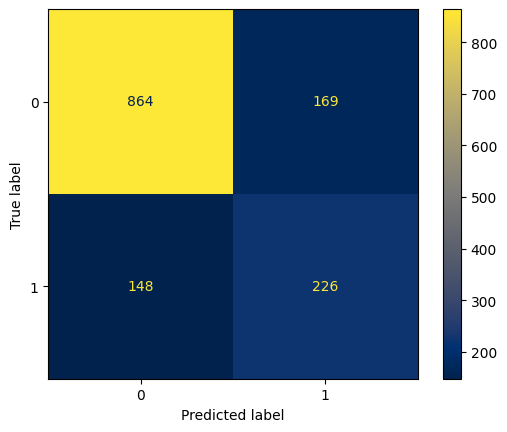

In [22]:
y_pred_xgb = xgb_clf.predict(X_test)
model_eval(xgb_clf,y_test,y_pred_xgb)

In [30]:
xgb_importances = pd.DataFrame({
    'Feature': X.columns,  
    'Importance': xgb_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

fig = px.bar(
    xgb_importances, 
    x='Importance', 
    y='Feature', 
    orientation='h', 
    title='Feature Importance - XGBoost',
    labels={'Importance': 'Importance', 'Feature': 'Feature'},
    height=600
)

fig.update_layout(yaxis=dict(autorange="reversed"))  
fig.show()

# Base Neural Network

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

baseNN = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),  
    Dropout(0.3),     
    Dense(64, activation='relu'),  
    Dropout(0.3),                               
    Dense(32, activation='relu'),               
    Dropout(0.3),                               
    Dense(1, activation='sigmoid')              
])

baseNN.compile(
    optimizer=Adam(learning_rate=0.001),        
    loss='binary_crossentropy',                 
    metrics=['accuracy']                        
)

baseNN.fit(
    X_train, y_train,
    epochs=20,                                  
    batch_size=32,                              
    validation_split=0.2,                       
    verbose=1                                   
)



Epoch 1/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - accuracy: 0.6703 - loss: 0.5972 - val_accuracy: 0.7760 - val_loss: 0.5875
Epoch 2/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.7621 - loss: 0.4924 - val_accuracy: 0.7760 - val_loss: 0.5431
Epoch 3/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.7747 - loss: 0.4784 - val_accuracy: 0.7548 - val_loss: 0.5390
Epoch 4/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - accuracy: 0.7804 - loss: 0.4725 - val_accuracy: 0.7554 - val_loss: 0.5878
Epoch 5/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.7907 - loss: 0.4623 - val_accuracy: 0.7482 - val_loss: 0.5738
Epoch 6/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.7830 - loss: 0.4515 - val_accuracy: 0.7264 - val_loss: 0.5669
Epoch 7/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.7925 - loss: 0.4496 - val_accuracy: 0.7785 - val_loss: 0.5131
Epoch 8/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.7828 - loss: 0.4576 - 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1033
           1       0.55      0.68      0.61       374

    accuracy                           0.77      1407
   macro avg       0.71      0.74      0.72      1407
weighted avg       0.79      0.77      0.77      1407

ROC_AUC_Score: 0.7385
F1 Score: 0.6074


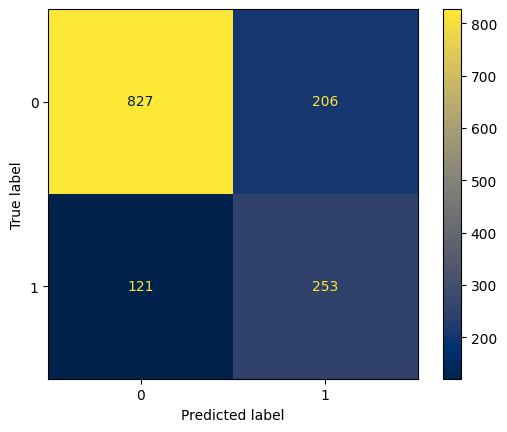

In [25]:
y_pred_baseNN = (baseNN.predict(X_test) > 0.5).astype("int32")  
model_eval(baseNN,y_test,y_pred_baseNN)